In [ ]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(1, os.path.join(sys.path[0], '..'))
sys.path.insert(1, os.path.join(sys.path[0], '.'))

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from src import data
from datetime import date
from io import StringIO

# Load Data

In [ ]:
orders_df = (
  pd
    .read_csv('../streamlit_app/data/orders.csv', parse_dates = ['order_date'])
    .reset_index()
    .rename(columns = {'index': 'order_id'})
    .assign(
      order_id = lambda df: df['order_id']+1,
      order_date = lambda df: pd.to_datetime(df['order_date'].dt.date)
    )
)
orders_df

Total portfolio cost

In [4]:
orders_df['order_cost_usd'].sum()

7809.18

In [5]:
# orders = [
#   #COST	2021-04-06, 09:30:01	360.12	2	720.24
#   {
#     'asset': 'COST',
#     'order_date': date(2021, 4, 6),
#     'order_id': 1,
#     'order_units': 2,
#     'unit_cost_usd': 360.12,
#   },
# ]

In [6]:
# orders_df = data.make_orders_df(orders)
assets = list(orders_df['asset'].unique())
prices_df = data.make_prices_df(assets)

[*********************100%***********************]  4 of 4 completed


/Users/calvindelima/projects/investing/.venv/lib/python3.8/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [7]:
order_value_snapshot_df = data.make_order_value_snapshot_df(
  prices_df,
  orders_df
)
asset_value_snapshot_df = data.make_asset_value_snapshot_df(
  order_value_snapshot_df
)
portfolio_value_snapshot_df = data.make_portfolio_value_snapshot_df(
  asset_value_snapshot_df
)

In [8]:
orders_df

,order_id,asset,order_date,unit_cost_usd,order_units,order_cost_usd
0,1,COST,2021-04-06,360.12,2,720.24
1,2,COST,2021-04-09,363.21,1,363.21
2,3,COST,2021-04-13,365.21,3,1095.63
3,4,COUR,2021-04-05,49.61,16,793.76
4,5,DHR,2021-04-09,232.36,5,1161.80
5,6,DHR,2021-04-13,242.84,6,1457.04
6,7,SOXX,2021-04-09,446.80,2,893.60
7,8,SOXX,2021-04-13,441.30,3,1323.90


In [9]:
prices_df.tail(5)

,price_date,asset,unit_price_usd
42759,2021-05-17,SOXX,401.030014
42760,2021-05-18,SOXX,401.410004
42761,2021-05-19,SOXX,397.935013
42762,2021-05-20,SOXX,412.520004
42763,2021-05-21,SOXX,416.660004


In [10]:
order_value_snapshot_df

,asset,price_date,order_date,order_id,order_units,unit_price_usd,order_cost_usd,order_value_usd
31971,COST,2021-04-06,2021-04-06,1,2,359.575119,720.24,719.150238
31974,COST,2021-04-07,2021-04-06,1,2,359.456528,720.24,718.913055
31977,COST,2021-04-08,2021-04-06,1,2,361.623947,720.24,723.247894
31980,COST,2021-04-09,2021-04-06,1,2,361.671814,720.24,723.343628
31981,COST,2021-04-09,2021-04-09,2,1,361.671814,363.21,361.671814
...,...,...,...,...,...,...,...,...
85523,SOXX,2021-05-19,2021-04-13,8,3,397.935013,1323.90,1193.805038
85524,SOXX,2021-05-20,2021-04-09,7,2,412.520004,893.60,825.040009
85525,SOXX,2021-05-20,2021-04-13,8,3,412.520004,1323.90,1237.560013
85526,SOXX,2021-05-21,2021-04-09,7,2,416.660004,893.60,833.320007


Portfolio value

In [11]:
order_value_snapshot_df.groupby('price_date')['order_value_usd'].sum().tail(1).values[0]

7771.534965515137

<ipython-input-12-b1c77f89d5a3>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45);


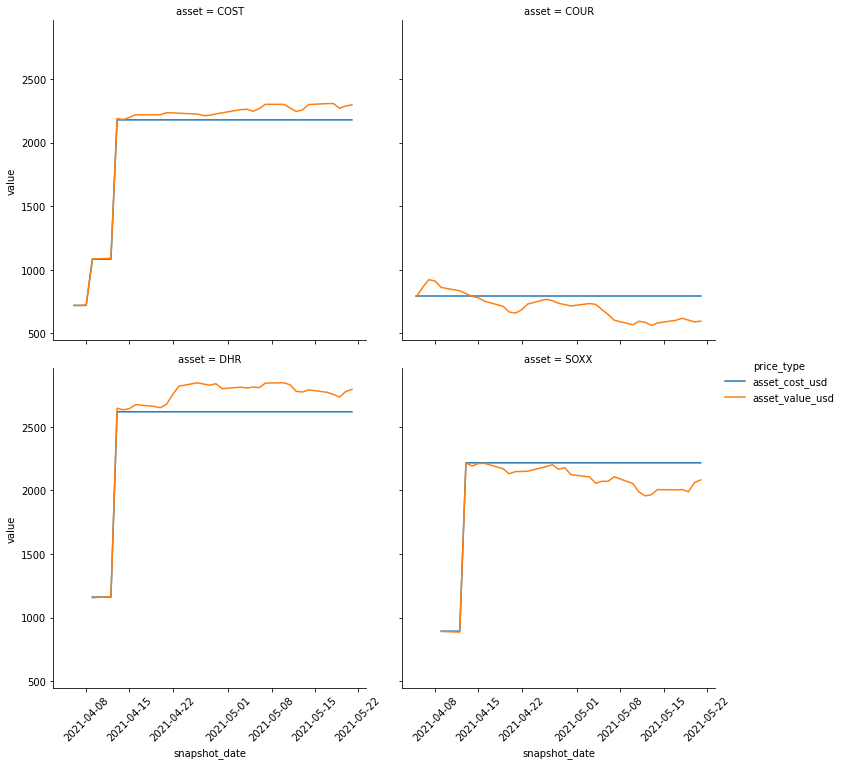

In [12]:
plot_df = (
  asset_value_snapshot_df
    .melt(
      id_vars = ['asset', 'snapshot_date'],
      var_name = 'price_type'
    )
)

# plot_df

g = sns.relplot(
  data = plot_df,
  col = 'asset',
  col_wrap = 2,
  x = 'snapshot_date',
  y = 'value',
  hue = 'price_type',
  kind = 'line'
);

for ax in g.axes.ravel():
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

In [13]:
portfolio_value_snapshot_df.head()

,snapshot_date,portfolio_cost_usd,portfolio_value_usd
0,2021-04-05,793.76,789.360016
1,2021-04-06,1514.00,1581.070221
2,2021-04-07,1514.00,1641.313049
3,2021-04-08,1514.00,1635.247894
4,2021-04-09,3932.61,3993.915436


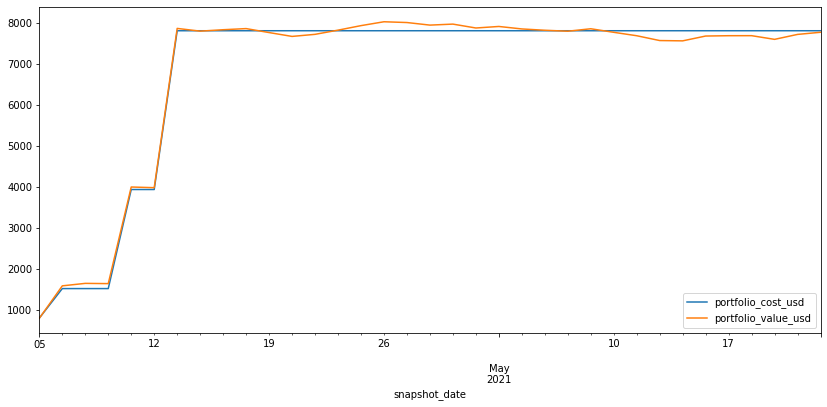

In [93]:
(
  portfolio_value_snapshot_df
    .set_index('snapshot_date')
    .plot(figsize = (14, 6))
);

In [94]:
subset_return_df = data.make_portfolio_value_snapshot_df(
  asset_value_snapshot_df.query('asset in ["COST", "DHR"]')
).assign(
  percent_return = lambda df: df['portfolio_value_usd'] / df['portfolio_cost_usd'] - 1
)
subset_return_df.tail(1)

,snapshot_date,portfolio_cost_usd,portfolio_value_usd,percent_return
33,2021-05-21,4797.92,5091.91497,0.061276


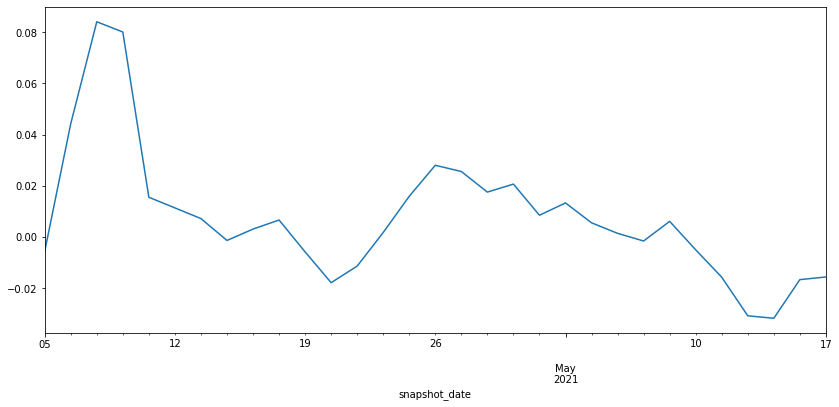

In [55]:
(
  portfolio_value_snapshot_df
    .set_index('snapshot_date')
    .assign(percent_return = lambda df: df['portfolio_value_usd'] / df['portfolio_cost_usd'] - 1)
    ['percent_return']
    .plot(figsize = (14, 6), ls = '-')
);

In [56]:
portfolio_return_series = (
  portfolio_value_snapshot_df
    .assign(
      percent_return = lambda df: df['portfolio_value_usd'] / df['portfolio_cost_usd'] - 1
    )
    .set_index('snapshot_date')
    ['percent_return']
)
# portfolio_return_series

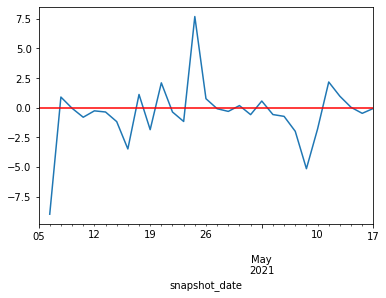

In [57]:
portfolio_return_series.pct_change().plot();
plt.axhline(0, color = 'red')

<AxesSubplot:xlabel='percent_return', ylabel='Count'>

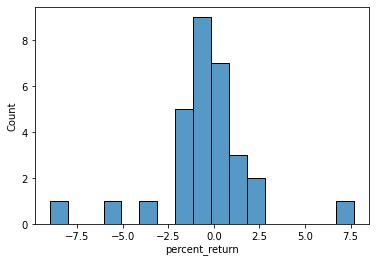

In [58]:
sns.histplot(portfolio_return_series.pct_change())